In [1]:
import numpy as np
import pandas as pd
from datascience import *
import matplotlib.pyplot as mp
mp.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data = pd.read_csv('leagues_performances.csv')

In [3]:
data.head()

,id,round,user,rank,highest_rank,balance_value,shares_value,total
0,1,1,1,90,70,495557.3,7167.5,502724.8
1,2,1,2,14,6,884963.1,199616.4,1084579.5
2,3,1,3,25,12,857638.9,-3904.0,853734.9
3,4,1,191,60,51,540069.0,0.0,540069.0
4,5,1,190,51,35,122100.0,430300.0,552400.0


In [4]:
data['score'] = data['total']/(data['highest_rank']*data['rank'])
data.head()

,id,round,user,rank,highest_rank,balance_value,shares_value,total,score
0,1,1,1,90,70,495557.3,7167.5,502724.8,79.797587
1,2,1,2,14,6,884963.1,199616.4,1084579.5,12911.660714
2,3,1,3,25,12,857638.9,-3904.0,853734.9,2845.783000
3,4,1,191,60,51,540069.0,0.0,540069.0,176.493137
4,5,1,190,51,35,122100.0,430300.0,552400.0,309.467787


In [5]:
data.drop(['id','balance_value','shares_value','rank','highest_rank','total'],axis=1,inplace=True)

In [6]:
data.head()

,round,user,score
0,1,1,79.797587
1,1,2,12911.660714
2,1,3,2845.783000
3,1,191,176.493137
4,1,190,309.467787


In [7]:
dataset = data.values

In [8]:
start_rating = 1000
'''
store user data in following format
'0':{

    'rating' : #player rating
    'round_1':{
        'expected_rank':, #after round over using elo scheme if first time give (total_participants/2) + 1
        'actual_rank':,   #after round over we know this
        'previous_rating' #use previous if first give a constant starting value say 1000 in our case
        'new_rating':,    #calculate using delta between actual and expected rank

    }
}
'''
users = {
}

'''
    'round_0':{
        'total_participants':,
        'standings':[
            {
                user:,
                new_rank:,

            }
        ],
    }
'''
rounds = {
}

In [9]:
for row in dataset:
    participant = list(row)
    participant[0] = int(participant[0])
    participant[1] = int(participant[1])
    user_id = participant[1]
    participant[2] = float(participant[2])
    round_number = participant[0]
    if  round_number not in rounds:
        rounds[round_number] = {}
        rounds[round_number]['total_participants'] = 0
        rounds[round_number]['standings'] = []
    rounds[round_number]['total_participants'] = rounds[round_number]['total_participants'] + 1
    rounds[round_number]['standings'].append(participant[1:])
    if user_id not in users:
        users[user_id] = {
            
        }
        users[user_id]['rating'] = 1000
        users[user_id]['rating_changes'] = []

In [10]:
for round_number in rounds:
    rounds[round_number]['standings'] = sorted(rounds[round_number]['standings'], key = lambda x: x[1],reverse=True)

In [11]:
for round_number in rounds:
    rank = 1
    for standing in rounds[round_number]['standings']:
        standing.append(rank)
        rank = rank + 1    

In [12]:
import json
f = open('rounds.txt','w')
f.write(json.dumps(rounds,indent=4))
f.close()
f = open('users.txt','w')
f.write(json.dumps(users,indent=4))
f.close()

In [13]:
#source : https://github.com/rshk/elo/blob/master/elo.py

def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def elo(old, exp, score, k=32):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 32)
    """
    return old + k * (exp - score)

In [14]:
for round_number in rounds:
    
    
    this_round = rounds[round_number]
    standings = this_round['standings']
    total_participants = this_round['total_participants']
    
    
    for standing in standings:        
        user_id = standing[0]        
            
        user = users[user_id]
        user_rating = user['rating']
        user['user_rounds'] = len(user.keys()) - 2
        if round_number not in user:
            user[round_number] = {}
            
        user[round_number]['previous_rating'] = user_rating
        probabilities_summation = 0
        
        for i in range(0,total_participants):
            opponent_id = this_round['standings'][i][0]
            opponent_rating = users[opponent_id]['rating']
            if opponent_id!=user_id:
                probabilities_summation = probabilities_summation + expected(user_rating,opponent_rating)
                
        seed = probabilities_summation  + 1   
        user[round_number]['seed'] = seed      
        user[round_number]['actual_rank'] = standing[2]
        standing.append(seed)
        
    this_round['standings'] = sorted(this_round['standings'], key = lambda x: x[3],reverse=True)
    expected_rank = 1
    
    for standing in this_round['standings']:
        standing.append(expected_rank)
        user = users[standing[0]]
        user[round_number]['expected_rank'] = expected_rank      
        if user['user_rounds'] == 0:
            user[round_number]['expected_rank'] = (total_participants//2 + 1)
        new_rating = elo(user['rating'],user[round_number]['expected_rank'],user[round_number]['actual_rank'])
        user[round_number]['new_rating'] = new_rating
        user['user_rounds'] = user['user_rounds'] + 1
        user['rating'] = new_rating
        user['rating_changes'].append(new_rating)
        expected_rank = expected_rank + 1  
        

In [15]:
f = open('rounds_done.txt','w')
f.write(json.dumps(rounds,indent=4))
f.close()
f = open('users_done.txt','w')
f.write(json.dumps(users,indent=4))
f.close()

In [16]:
users[3]

{1: {'actual_rank': 24,
  'expected_rank': 114,
  'new_rating': 3880,
  'previous_rating': 1000,
  'seed': 113.5},
 'rating': 4776,
 3: {'actual_rank': 8,
  'expected_rank': 96,
  'new_rating': 5064,
  'previous_rating': 2248,
  'seed': 183.27571919963773},
 4: {'actual_rank': 12,
  'expected_rank': 3,
  'new_rating': 4776,
  'previous_rating': 5064,
  'seed': 280.2878742699927},
 'rating_changes': [3880, 2248, 5064, 4776],
 2: {'actual_rank': 75,
  'expected_rank': 24,
  'new_rating': 2248,
  'previous_rating': 3880,
  'seed': 235.92899996893036},
 'user_rounds': 5}

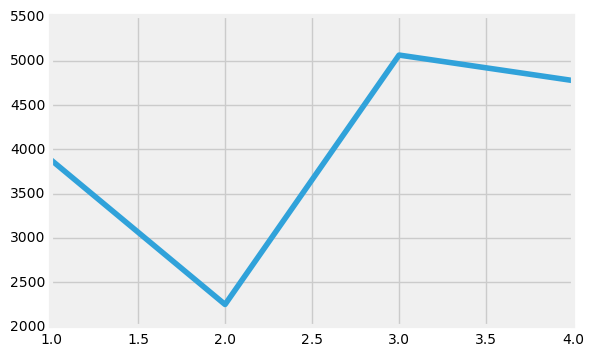

In [17]:
mp.plot(np.arange(1,users[3]['user_rounds'],1),users[3]['rating_changes'])

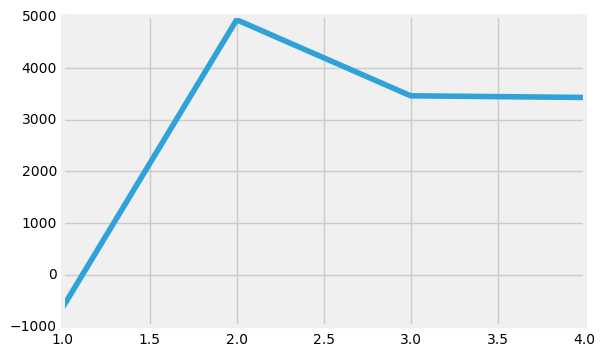

In [20]:
mp.plot(np.arange(1,users[11]['user_rounds'],1),users[11]['rating_changes'])